In [1]:
# imports
import json
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from utils.items import Item
from utils.loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
import pandas as pd
import  numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.utils import simple_preprocess

In [4]:
GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
RESET= "\033[0m"


In [5]:
load_dotenv()
# login to huggingface hub
login(os.getenv("HF_TOKEN"), add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
%matplotlib inline

In [7]:
with open("train.pkl", "rb") as f:
    train = pickle.load(f)
with open("test.pkl", "rb") as f:
    test = pickle.load(f)

In [8]:
print(train[0].prompt)
train[0].price

How much does this cost to the nearest dollar?

Lutema Mitsubishi Replacement DLP/LCD Cinema Projector Lamp with OSRAM Inside
Lutema Osram Inside Replacement Lamp for Mitsubishi Part Number This lamp provides OPTIMAL Brightness and is the Longest-Lasting Replacement Lamp for your Mitsubishi DLP / LCD Projection Television. Lutema Osram Inside Replacement Lamps are rated BEST lifetime and restore 100% of your Projectors brightness. Compatible with the following projector models Replaces - Lutema Osram Inside replacement lamp provides a 100% the lifetime and brightness of your factory original replacement lamp for your DLP / LCD Cinema Projector. Compatible with these Projector Model Numbers Product has been certified by MI Technologies, Inc. in North America to meet the highest quality standards in the industry. This item is a best solution for

Price is $52.00


51.72

In [9]:
for i in range(len(test)):
    test[i].prompt = test[i].prompt.split("Price is ")[0] + "Price is"

In [10]:
test[0].prompt

'How much does this cost to the nearest dollar?\n\nIgloo 110V AC Power Converter for Iceless Kool Mate Cool Chill Thermolectric Coolers\nWhether you’re taking a day-trip to the beach, heading off for a weekend camping adventure, or relaxing at an afternoon cookout, you can count on Igloo to have an ice chest cooler to fit your needs. Hard coolers make the perfect option for safe, reliable storage that will keep your snacks and beverages cold all day. And all of our hard coolers made in our USA facility incorporate THERMECOOL™ insulation. This innovative foam lowers CO2 and VOC emissions, so we’re lowering our environmental impact while creating coolers that can last a lifetime. Igloo 110V AC Power Converter for Iceless Kool Mate Cool Chill Thermoelectric Coolers\n\nPrice is'

In [11]:
train[0].details # a string not a json

'{"Brand": "Lutema", "Wattage": "40 watts", "Specific Uses For Product": "Lamp", "Unit Count": "1.0 Count", "Number of Items": "1", "Brightness": "3800 Lumen", "Indoor/Outdoor Usage": "Indoor", "Style": "Osram Inside", "Color Rendering Index": "100", "Product Dimensions": "7 x 5 x 6 inches", "Item Weight": "10.6 ounces", "Manufacturer": "MI Technologies, Inc.", "Country of Origin": "Mexico", "Item model number": "VLT-HC3800LP-P02", "Best Sellers Rank": {"Projection Lamps": 4690}, "Is Discontinued By Manufacturer": "No", "Date First Available": "May 8, 2015"}'

In [12]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [13]:
train[0].features

{'Brand': 'Lutema',
 'Wattage': '40 watts',
 'Specific Uses For Product': 'Lamp',
 'Unit Count': '1.0 Count',
 'Number of Items': '1',
 'Brightness': '3800 Lumen',
 'Indoor/Outdoor Usage': 'Indoor',
 'Style': 'Osram Inside',
 'Color Rendering Index': '100',
 'Product Dimensions': '7 x 5 x 6 inches',
 'Item Weight': '10.6 ounces',
 'Manufacturer': 'MI Technologies, Inc.',
 'Country of Origin': 'Mexico',
 'Item model number': 'VLT-HC3800LP-P02',
 'Best Sellers Rank': {'Projection Lamps': 4690},
 'Is Discontinued By Manufacturer': 'No',
 'Date First Available': 'May 8, 2015'}

In [14]:
# Now we can easily find the most common features in the dataset
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f] += 1

In [15]:
feature_count.most_common(10)

[('Date First Available', 135206),
 ('Item Weight', 124005),
 ('Brand', 116795),
 ('Best Sellers Rank', 116421),
 ('Manufacturer', 113504),
 ('Item model number', 104918),
 ('Product Dimensions', 90270),
 ('Color', 62648),
 ('Is Discontinued By Manufacturer', 56648),
 ('Special Feature', 39778)]

## Now time for some Feature Engineering

In [16]:
for i in range(10):
    print(train[i].features['Item Weight'])

10.6 ounces
3 pounds
1.5 Pounds
6 pounds
2.55 pounds
3.45 pounds
5 Kilograms
10.6 ounces
1.36 pounds
2.89 ounces


In [17]:
# different weights for different columns!!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [18]:
weights = [get_weight(item) for item in train]
weights = [w for w in weights if w]

In [19]:
average_weight = sum(weights) / len(weights)
average_weight

4.648708025795095

In [20]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [21]:
def get_rank(item):
    rank_dict = item.features.get('Best Sellers Rank')
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [22]:
ranks = [get_rank(item) for item in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks) / len(ranks)
average_rank

77051.81968213385

In [23]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [24]:
def get_text_length(item):
    return len(item.test_prompt())

In [25]:
brands = Counter()

for t in train:
    brand = t.features.get('Brand')
    if brand:
        brands[brand] += 1

brands.most_common(10)

[('HP', 4652),
 ('Dell', 3383),
 ('Lenovo', 2535),
 ('Sony', 1548),
 ('SAMSUNG', 1514),
 ('ASUS', 1505),
 ('Canon', 884),
 ('Intel', 794),
 ('Apple', 726),
 ('Garmin', 608)]

In [26]:
TOP_BRANDS = [b[0] for b in brands.most_common(20)]

def is_top_brand(item):
    brand = item.features.get('Brand')
    return brand in TOP_BRANDS if brand else 0

In [27]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "top_brand": is_top_brand(item)
    }

In [28]:
get_features(train[1])

{'weight': 3.0, 'rank': 6399.0, 'text_length': 620, 'top_brand': False}

In [29]:
def list_to_dataframe(items):
        features = [get_features(item) for item in items]
        df = pd.DataFrame(features)
        df['price'] = [item.price for item in items]
        return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test)


In [30]:
np.random.seed(42)

feature_columns = ['weight', 'rank', 'text_length', 'top_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}") # how much each 
                                #feature contributes to the price
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.9656513066718
rank: -2.5895397713413155e-05
text_length: -0.11351750023148766
top_brand: 186.2082676996691
Intercept: 221.43380953654776
Mean Squared Error: 31877.673056695665
R-squared Score: 0.1492871347598952


In [31]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

In [32]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [33]:
prices[0]

51.72

In [34]:
# Use the count vectorizer to create a bag of words representation
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents).toarray()
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [35]:
# metrics
mse = mean_squared_error(prices, regressor.predict(X))
r2 = r2_score(prices, regressor.predict(X))
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Intercept: {regressor.intercept_}")

Mean Squared Error: 21174.959425279987
R-squared Score: 0.4486160312363753
Intercept: 205.4914495532457


Text(0.5, 0, 'True Prices')

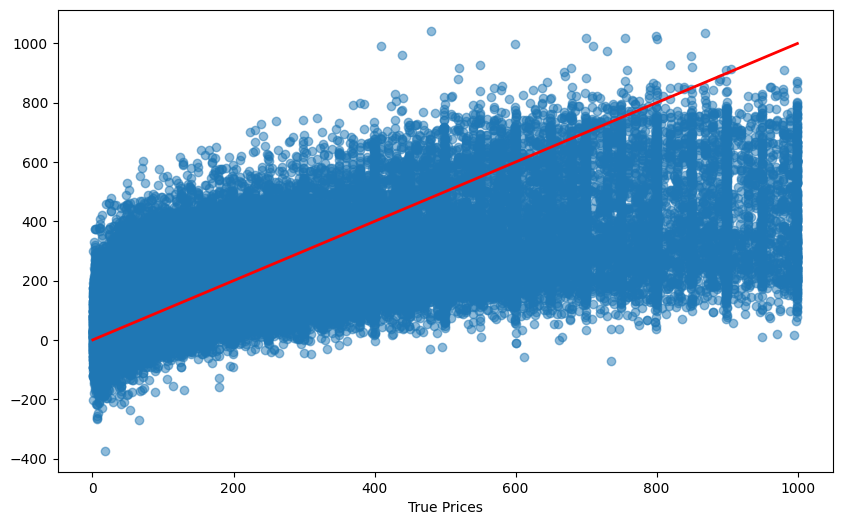

In [36]:
# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.scatter(prices, regressor.predict(X), alpha=0.5)
plt.plot([min(prices), max(prices)], [min(prices), max(prices)], color='red', lw=2)
plt.xlabel('True Prices')


## Using Word2Vec model

In [37]:
np.random.seed(42)

processed_docs = [simple_preprocess(doc) for doc in documents]
w2v_model = Word2Vec(processed_docs, vector_size=400, window=5, min_count=1, workers=4)

In [ ]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)
    
X_w2v = np.array([document_vector(doc) for doc in documents])

In [39]:
word2vec_lr = LinearRegression()
word2vec_lr.fit(X_w2v, prices)

LinearRegression()

In [40]:
# metrics
mse = mean_squared_error(prices, regressor.predict(X))
r2 = r2_score(prices, regressor.predict(X))
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Intercept: {regressor.intercept_}")

Mean Squared Error: 21174.959425279987
R-squared Score: 0.4486160312363753
Intercept: 205.4914495532457


Text(0, 0.5, 'Predicted Prices')

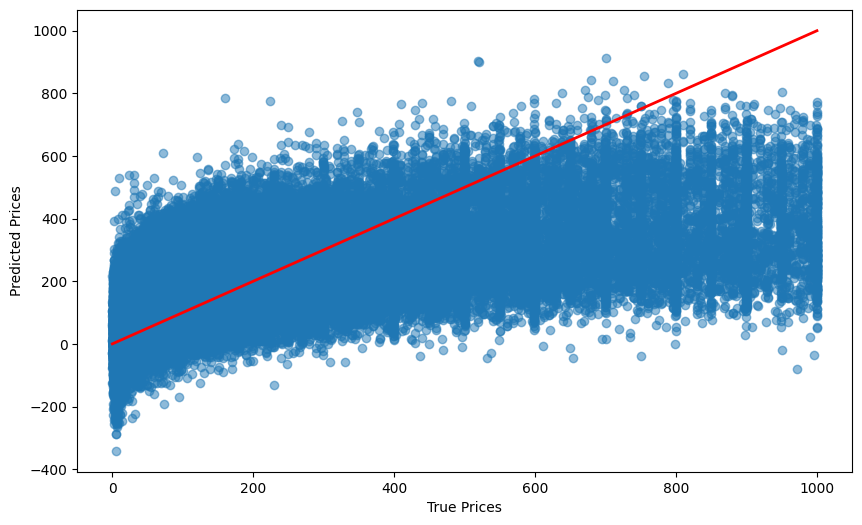

In [41]:
# let's visualize the predictions
plt.figure(figsize=(10, 6))
plt.scatter(prices, word2vec_lr.predict(X_w2v), alpha=0.5)
plt.plot([min(prices), max(prices)], [min(prices), max(prices)], color='red', lw=2)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')

## Time to Use SVR and Random Forest Regressor

In [42]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# X_reduced = pca.fit_transform(X_w2v)
# svr_regressor = SVR()

# svr_regressor.fit(X_reduced, prices)
# # took a million years to run SVR trying dimensional reduction

In [43]:
# # metrics
# mse = mean_squared_error(prices, regressor.predict(X))
# r2 = r2_score(prices, regressor.predict(X))
# print(f"Mean Squared Error: {mse}")
# print(f"R-squared Score: {r2}")
# print(f"Intercept: {regressor.intercept_}")

In [44]:
# # visualize the predictions
# plt.figure(figsize=(10, 6))
# plt.scatter(prices, svr_regressor.predict(X_reduced), alpha=0.5)
# plt.plot([min(prices), max(prices)], [min(prices), max(prices)], color='red', lw=2)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_w2v, prices)

In [ ]:
# metrics
mse = mean_squared_error(prices, rf_model.predict(X_w2v))
r2 = r2_score(prices, rf_model.predict(X_w2v))
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Intercept: {regressor.intercept_}")

In [ ]:
# visualize the predictions
plt.figure(figsize=(10, 6))
plt.scatter(prices, rf_model.predict(X_w2v), alpha=0.5)
plt.plot([min(prices), max(prices)], [min(prices), max(prices)], color='red', lw=2)

## Ok now let's try a better way to visualize!

## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [ ]:
import math

class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [ ]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(bow_lr_pricer)

NameError: name 'Tester' is not defined